# 🎬 **Content-Based Movie Recommendation Engine using Unsupervised Learning**
**By: Vishwaraj Khatpe | Final Year Engineering Student (AIML)**

---

## 1. Executive Summary
In the era of streaming services, users face "choice paralysis" due to the overwhelming abundance of content. This project aims to solve this by building a Recommendation System that clusters movies based on their inherent features (Genres, Popularity, and User Ratings).

Unlike Collaborative Filtering (which requires user history), this Content-Based approach uses **K-Means Clustering** to identify latent patterns in movie metadata, enabling cold-start recommendations for new users.

---

## 2. Project Objectives

* **Data Pipeline:** Ingest and parse complex metadata (JSON formats).
* **Feature Engineering:** Transform categorical data using One-Hot Encoding and normalize numerical metrics using Min-Max Scaling.
* **Modeling:** Implement K-Means Clustering to group semantically similar movies.
* **Optimization:** Use the **Elbow Method** and **Silhouette Analysis** to determine the optimal number of clusters ($k$).
* **Inference:** Build a query function to return top $N$ recommendations for a given movie title.

In [1]:
# Core Data Analysis Libraries
import pandas as pd
import numpy as np
import ast  # For parsing stringified JSON lists

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Libraries
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Configuration for cleaner output
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot') # Professional plotting style

print(" Libraries Imported Successfully")

 Libraries Imported Successfully


# **Data Loading**

## 3. Data Acquisition and Inspection

We utilize the Movie Metadata dataset. The initial step involves loading the data and inspecting the schema to identify necessary cleaning steps.

In [9]:
# Load the dataset
# Ensure 'movies_metadata.csv' is in the same directory
try:
    df = pd.read_csv("../data/movies_metadata.csv", low_memory=False)
    print(f"Dataset Shape: {df.shape}")
    print("Columns:", df.columns.tolist())
except FileNotFoundError:
    print(" Error: File not found. Please upload 'movies_metadata.csv'.")

# Filter for relevant features to reduce dimensionality and noise
# We focus on Title (Identifier), Genres (Content), Vote Average (Quality), and Popularity (Trend)
selected_columns = ['title', 'genres', 'vote_average', 'popularity']
movies = df[selected_columns].copy()

# Data Cleaning: Drop rows with null values in critical columns to ensure model stability
movies = movies.dropna(subset=selected_columns)

# Convert numerical columns to numeric types (forcing errors to NaN then dropping)
movies['popularity'] = pd.to_numeric(movies['popularity'], errors='coerce')
movies['vote_average'] = pd.to_numeric(movies['vote_average'], errors='coerce')
movies = movies.dropna()

print(f"Cleaned Dataset Shape: {movies.shape}")
movies.head(3)

Dataset Shape: (45466, 24)
Columns: ['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id', 'imdb_id', 'original_language', 'original_title', 'overview', 'popularity', 'poster_path', 'production_companies', 'production_countries', 'release_date', 'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title', 'video', 'vote_average', 'vote_count']
Cleaned Dataset Shape: (45460, 4)


,title,genres,vote_average,popularity
0,Toy Story,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",7.7,21.946943
1,Jumanji,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",6.9,17.015539
2,Grumpier Old Men,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",6.5,11.712900


# **Feature Engineering**

## 4. Feature Engineering & Preprocessing

Raw data cannot be fed directly into machine learning models. We need to perform two specific transformations:

* **Parsing & Encoding Genres:** The genres column contains list-of-dictionaries stored as strings. We need to parse this and apply **Multi-Label Binarization** (similar to One-Hot Encoding) to turn genres into mathematical vectors.
* **Feature Scaling:** K-Means uses Euclidean Distance. If popularity ranges from 0-500 and vote_average ranges from 0-10, the model will be biased toward popularity. We use **MinMax Scaling** to bring all features into the range $[0, 1]$.

### [Code] - Feature Engineering

In [10]:
# 4.1 Parsing JSON Genres
def parse_genres(genre_str):
    """
    Parses stringified JSON to extract genre names.
    Input: "[{'id': 28, 'name': 'Action'}, ...]"
    Output: ['Action', ...]
    """
    try:
        genres = ast.literal_eval(genre_str)
        return [g['name'] for g in genres]
    except:
        return []

movies['genre_list'] = movies['genres'].apply(parse_genres)

# 4.2 Encoding Genres (MultiLabelBinarizer)
mlb = MultiLabelBinarizer()
genre_encoded = mlb.fit_transform(movies['genre_list'])
genre_df = pd.DataFrame(genre_encoded, columns=mlb.classes_, index=movies.index)

# 4.3 Scaling Numerical Features
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(movies[['vote_average', 'popularity']])
scaled_df = pd.DataFrame(scaled_features, columns=['vote_average', 'popularity'], index=movies.index)

# 4.4 Constructing the Final Feature Matrix
final_features = pd.concat([genre_df, scaled_df], axis=1)

print("Feature Matrix Shape:", final_features.shape)
final_features.head(3)

Feature Matrix Shape: (45460, 22)


,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,...,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western,vote_average,popularity
0,0,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0.77,0.040087
1,0,1,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0.69,0.031079
2,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0.65,0.021394


# 5. **Exploratory Data Analysis (EDA)**

Understanding the distribution of genres helps us verify if the dataset is balanced or skewed towards specific categories like Drama or Comedy.

### [Code] - EDA Visualization

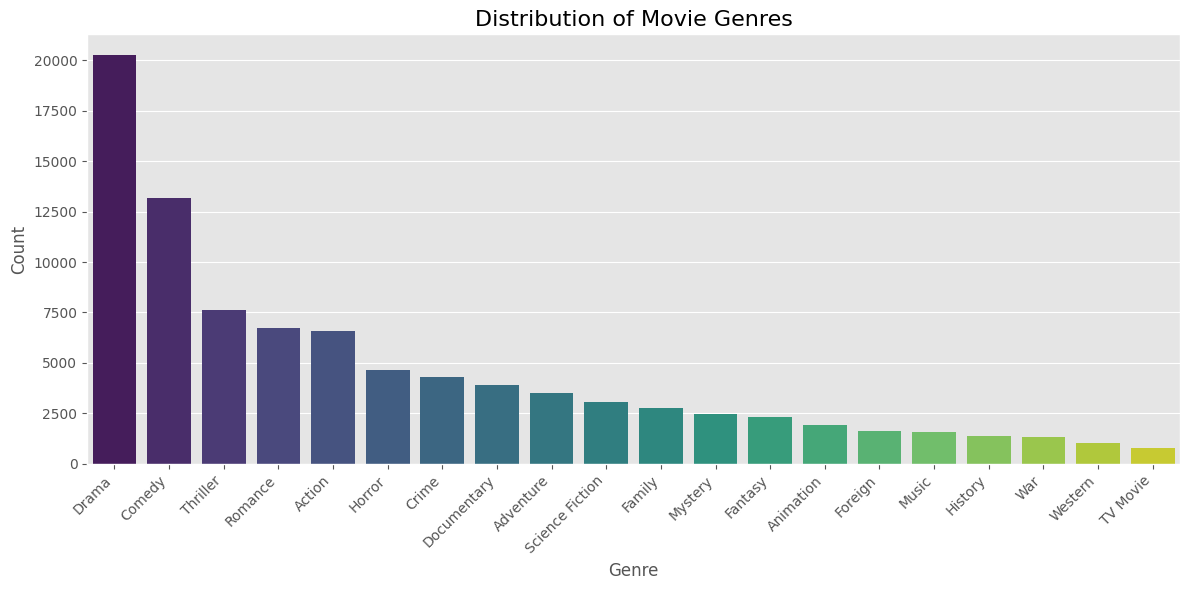

In [11]:
# Calculate genre counts
genre_counts = movies['genre_list'].explode().value_counts().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='viridis')
plt.title('Distribution of Movie Genres', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Count')
plt.xlabel('Genre')
plt.tight_layout()
plt.show()

# **Modeling Strategy**


## 6. Unsupervised Learning: Clustering

To group movies, we use **K-Means Clustering**. However, choosing the arbitrary number of clusters ($k$) is difficult. We use two metrics to find the optimal $k$:

* **Inertia (Elbow Method):** Measures how tightly grouped the clusters are. We look for the "elbow" where improvements flatten out.
* **Silhouette Score:** Measures how similar an object is to its own cluster compared to other clusters. Higher is better.

### [Code] - Hyperparameter Tuning (Elbow Method)

 Training K-Means models to find optimal K...


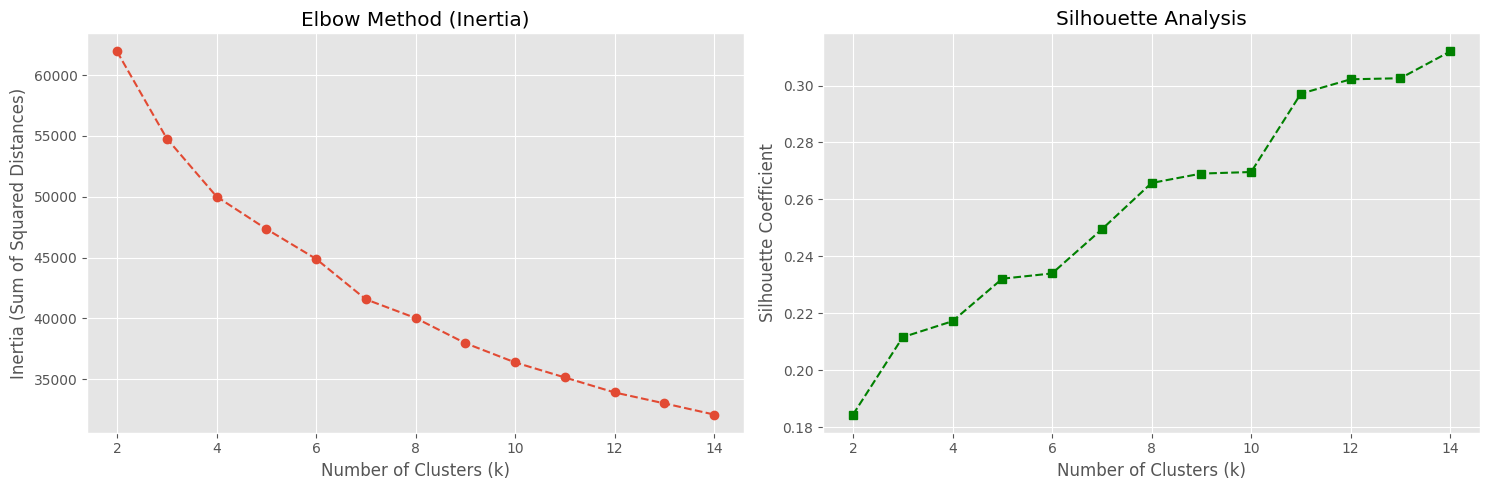

In [30]:
# NOTE: This cell involves heavy computation. We limit the range for demonstration.
inertia_values = []
silhouette_scores = []
k_range = range(2, 15)  # Analyzing k from 2 to 14

print(" Training K-Means models to find optimal K...")

for k in k_range:
    # random_state ensures reproducibility
    kmeans_model = KMeans(n_clusters=k, random_state=42, n_init=10) 
    kmeans_model.fit(final_features)
    inertia_values.append(kmeans_model.inertia_)
    
    # We sample the silhouette score for speed (optional optimization for large datasets)
    score = silhouette_score(final_features, kmeans_model.labels_, sample_size=5000)
    silhouette_scores.append(score)

# Plotting the evaluation metrics
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Elbow Curve
axs[0].plot(k_range, inertia_values, marker='o', linestyle='--')
axs[0].set_title('Elbow Method (Inertia)')
axs[0].set_xlabel('Number of Clusters (k)')
axs[0].set_ylabel('Inertia (Sum of Squared Distances)')

# Plot 2: Silhouette Score
axs[1].plot(k_range, silhouette_scores, marker='s', color='green', linestyle='--')
axs[1].set_title('Silhouette Analysis')
axs[1].set_xlabel('Number of Clusters (k)')
axs[1].set_ylabel('Silhouette Coefficient')

plt.tight_layout()
plt.show()

# 7. **Final Model Training**

Based on the graphs above (typically around $k=10$ to $k=20$ provides a good balance for movie genres), we will train the final model.

> **Note:** We select a $K$ that maximizes the Silhouette score while keeping the cluster distinct enough.

### [Code] - Final Training

 Training Complete. Movies grouped into 10 clusters.


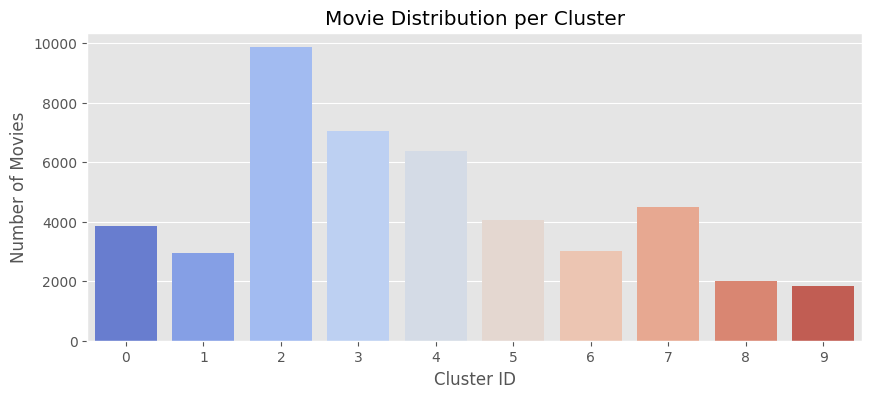

In [29]:
# Optimal K selected based on domain knowledge and previous graphs
OPTIMAL_K = 10 

final_model = KMeans(n_clusters=OPTIMAL_K, random_state=42)
movies['cluster'] = final_model.fit_predict(final_features)

print(f" Training Complete. Movies grouped into {OPTIMAL_K} clusters.")

# Visualize Cluster Distribution
plt.figure(figsize=(10, 4))
sns.countplot(x=movies['cluster'], palette='coolwarm')
plt.title('Movie Distribution per Cluster')
plt.xlabel('Cluster ID')
plt.ylabel('Number of Movies')
plt.show()

# **Recommendation Engine**


## 8. Inference Engine

The recommendation logic works as follows:

1.  **Input:** User provides a movie title.
2.  **Cluster Identification:** Find which cluster the input movie belongs to.
3.  **Filtration:** Select all other movies in that same cluster.
4.  **Ranking:** Sort these similar movies by **Vote Average (Quality)** and **Popularity (Trend)** to suggest the "best" matches first.

### [Code] - Recommendation Function

In [ ]:
def recommend_movies(movie_title, n=5):
    """
    Recommends N movies based on the cluster of the input movie.
    
    Args:
        movie_title (str): The name of the movie the user likes.
        n (int): Number of recommendations to return.
        
    Returns:
        DataFrame: Top N recommended movies.
    """
    # 1. Input Validation (Case insensitive search)
    movie_match = movies[movies['title'].str.lower() == movie_title.lower()]
    
    if movie_match.empty:
        return f" Movie '{movie_title}' not found in the database. Please check the spelling."
    
    # 2. Get Cluster ID
    target_cluster = movie_match['cluster'].values[0]
    
    # 3. Filter movies in the same cluster, excluding the input movie
    similar_movies = movies[
        (movies['cluster'] == target_cluster) & 
        (movies['title'].str.lower() != movie_title.lower())
    ]
    
    # 4. Rank by Quality (Rating) and Popularity
    recommendations = similar_movies.sort_values(
        by=['vote_average', 'popularity'], 
        ascending=[False, False]
    ).head(n)
    
    return recommendations[['title', 'vote_average', 'popularity', 'genre_list']]

In [27]:
# --- Test the System ---
test_movie = "Toy Story"
print(f" Recommendations for viewers who liked '{test_movie}':")
recommend_movies(test_movie, n=5)

 Recommendations for viewers who liked 'Toy Story':


,title,vote_average,popularity,genre_list
41695,Крепость: щитом и мечом,10.0,0.349582,"[War, Animation, Adventure]"
25689,Back to School with Franklin,10.0,0.040437,"[Animation, Family, Adventure]"
20943,King of Katoren,9.5,0.369340,"[Family, Adventure]"
42155,Kizumonogatari Part 3: Reiketsu,9.4,3.519786,"[Animation, Fantasy, Mystery]"
30233,Tony 10,9.0,0.412313,"[Foreign, Family]"


In [28]:
# --- Test the System with user input ---
movie_name = input("Enter the movie name: ")
print(f" Recommendations for viewers who liked '{movie_name}': ")
recommend_movies(movie_name,n=5)

 Recommendations for viewers who liked 'star wars': 


,title,vote_average,popularity,genre_list
45371,LEGO DC Super Hero Girls: Brain Drain,10.0,8.413734,[Animation]
36400,Mad at the Moon,10.0,1.225055,[]
30833,Mortal Kombat: The Journey Begins,10.0,0.714715,"[Action, Animation]"
34348,Brave Revolutionary,10.0,0.318826,[]
35017,Cattle Town,10.0,0.314719,[Western]


# **Conclusion**


## 9. Conclusion and Future Scope

### Summary
We successfully built a Content-Based Recommendation System. By engineering features from Genres and User Metrics, we utilized K-Means Clustering to segment movies into distinct groups. The system can now suggest movies similar to a user's preference without needing historical user data.

---

### Future Scope
To further enhance this system for a production environment (like my future role as an AIML Engineer), I would implement:

1.  **NLP Techniques:** Apply **TF-IDF** or **BERT** embeddings on the overview (plot summary) column to catch semantic similarities beyond just genres.
2.  **Hybrid Filtering:** Incorporate a **Collaborative Filtering** layer (Matrix Factorization) to personalize results based on specific user behavior.
3.  **Deployment:** Serve this model via a **Flask/FastAPI** endpoint and containerize it using **Docker**.